In [60]:
import os
import git
import sys

git_repo = git.Repo(os.getcwd(), search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")

res_path = os.path.join(git_root, 'results_test')

sys.path.append(git_root)

from abm_vec.one_period_sim import run_one_sim
from abm_vec.initialization import get_bank_data
from abm_vec.calibration import get_calibration_variables

from scipy.optimize import minimize
from scipy.stats import kstest
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from abm_vec.essentials.util import get_git_root_directory
import numpy as np
import random
from scipy import stats
import time
from joblib import Parallel, delayed
import pickle

In [61]:
bank_data = get_bank_data()
calibration_variables = get_calibration_variables()

In [62]:
covered_p = np.linspace(0,0.9, 11)
naked_p = np.linspace(0,0.05, 11)

deposit = -2.5

In [63]:
import _pickle as cPickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

In [64]:
results_dir = os.path.join(git_root, 'results')

In [65]:
result_file_names = next(os.walk(results_dir), (None, None, []))[2]
result_file_names = [x for x in result_file_names if '-2.5.pkl' in x]

In [67]:
data = list()
for x in result_file_names:
    file = x.split('_')
    covered = round(float(file[1]),3)
    naked = round(float(file[2]),3)
    deposit = round(float(file[3].split('.')[0]),3)
    with open(os.path.join(results_dir, x), "rb") as input_file:
        results = cPickle.load(input_file)
    for i in range(len(results)):
        prior_equity = results[i][0]['banks']['bank_equity']
        post_equity = results[i][1]['banks']['bank_equity']
        data.append({'covered': covered, 'naked': naked, 'deposit': deposit, 'prior_equity': prior_equity,
                    'post_equity': post_equity})

In [68]:
data= pd.DataFrame(data)

In [69]:
def compute_h(prior, post):
    return np.minimum(1, (prior - post) / prior)

In [70]:
def compute_global_vulnerability(row):
    return sum(row['prior_equity'] * row['individual_vulnerability'])/sum(row['prior_equity'])

In [71]:
data['individual_vulnerability'] = data.apply(lambda row: compute_h(row['prior_equity'], row['post_equity']), axis=1)

In [72]:
data['global_vulnerability'] = data.apply(lambda row: compute_global_vulnerability(row), axis=1)

In [73]:
def compute_mean_and_ci(x):
    mean = np.mean(x)
    std_error = np.std(x, ddof=1) / np.sqrt(len(x))
    confidence_level = 0.95
    dof = len(data) - 1

    # Critical value (t-distribution)
    t_critical = stats.t.ppf((1 + confidence_level) / 2, dof)
    
    # Calculate the confidence interval
    margin_of_error = t_critical * std_error
    confidence_interval = (mean - margin_of_error, mean + margin_of_error)
    return mean, confidence_interval

In [74]:
res_data = []

In [75]:
for covered in data.covered.unique():
    for naked in data.naked.unique():
        for deposit in data.deposit.unique():
            df = data[(data.covered == covered) & 
                      (data.naked == naked) & 
                      (data.deposit == deposit)
            ]
            median_av, median_ci = compute_mean_and_ci(df['global_vulnerability'].values)
            res_data.append({
                'covered': covered, 'naked': naked, 'deposit': deposit,
                'median_av': median_av, 'median_ci': median_ci, 
            })

In [76]:
res_data = pd.DataFrame(res_data)

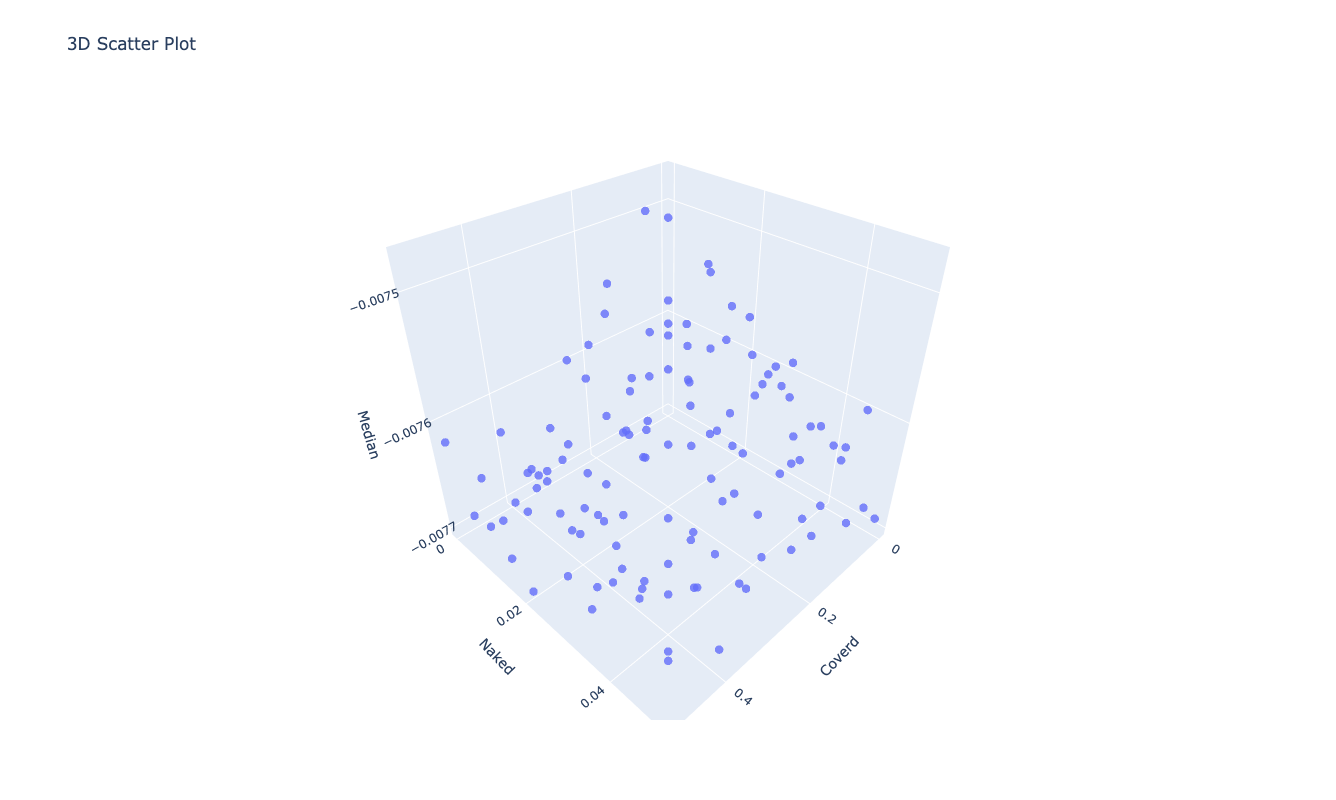

In [77]:
import plotly.graph_objects as go
import pandas as pd

# Assuming 'df' is your DataFrame
# df = pd.DataFrame(...) # Load your data here

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=res_data['covered'],
    y=res_data['naked'],
    z=res_data['median_av'],
    mode='markers',
    marker=dict(
        size=5,
        opacity=0.8
    )
)])

# Adding labels and title
fig.update_layout(
    width=800,  # Width in pixels
    height=800,
    scene = dict(
        xaxis_title='Coverd',
        yaxis_title='Naked',
        zaxis_title='Median'),
    title="3D Scatter Plot"
)

# Show plot
fig.show()
